## IMA205 challenge 
goal detect skin legions

1. Data Collection:

we have the given data 
todo :\
[] explore the data \
[] understand the data \
[] visualize the data \
[] clean the data \
[] preprocess the data



#### 1.1 Data exploration 
we have the following data : 
- a train set of images : 18998
- a test set of images : 6333
- a csv file with the labels of the train set 
- a csv file with the labels of the test set
### Metadata Files:

#### metadataTrain.csv
Contains metadata information and class labels for all training images.

**Columns:**
- **ID**: Unique identifier for each image (e.g., ISIC_0055289).
- **CLASS**: Class label of the image (integer between 1 and 8).
- **Age**: Age of the patient, when available.
- **Sex**: Gender of the patient, when available.
- **Anatomical Location**: Location of the lesion on the body, when available.

#### metadataTest.csv
Contains metadata information for all test images.

**Columns:**
- **ID**: Unique identifier for each image (e.g., ISIC_0055289).
- **Age**: Age of the patient, when available.
- **Sex**: Gender of the patient, when available.
- **Anatomical Location**: Location of the lesion on the body, when available.


In [1]:
print("hello")

hello


In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch

#test torch on gpu 

print(torch.cuda.is_available())

False


Training Metadata:
             ID  CLASS     SEX   AGE         POSITION
0  ISIC_0028766      2    male  30.0              NaN
1  ISIC_0071222      8    male  85.0  lower extremity
2  ISIC_0069434      3    male  85.0        head/neck
3  ISIC_0062098      1    male  55.0        head/neck
4  ISIC_0057224      8  female  45.0  lower extremity

Test Metadata:
             ID     SEX   AGE         POSITION
0  ISIC_0055289  female  50.0  lower extremity
1  ISIC_0062682    male  65.0  lower extremity
2  ISIC_0057706  female  75.0              NaN
3  ISIC_0031702    male  70.0        head/neck
4  ISIC_0069272    male  60.0  lower extremity

Training Metadata Summary:
                  ID         CLASS    SEX           AGE        POSITION
count          18998  18998.000000  18714  18674.000000           17028
unique         18998           NaN      2           NaN               8
top     ISIC_0028766           NaN   male           NaN  anterior torso
freq               1           NaN   9978  

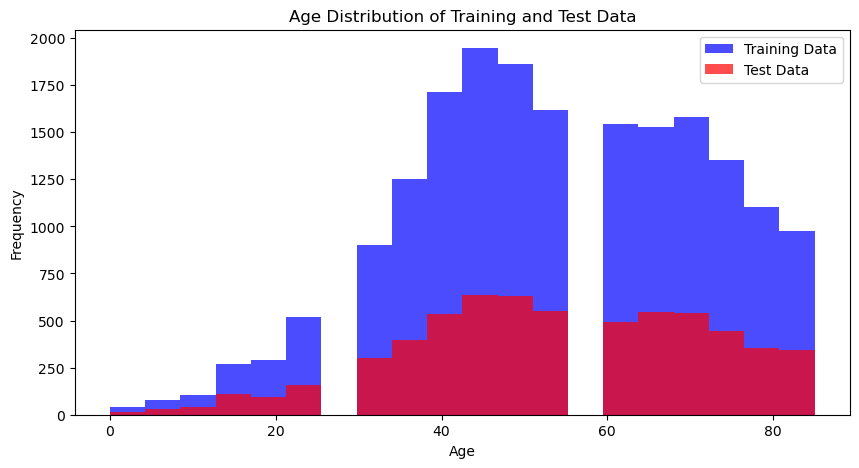

TypeError: 'value' must be an instance of str or bytes, not a float

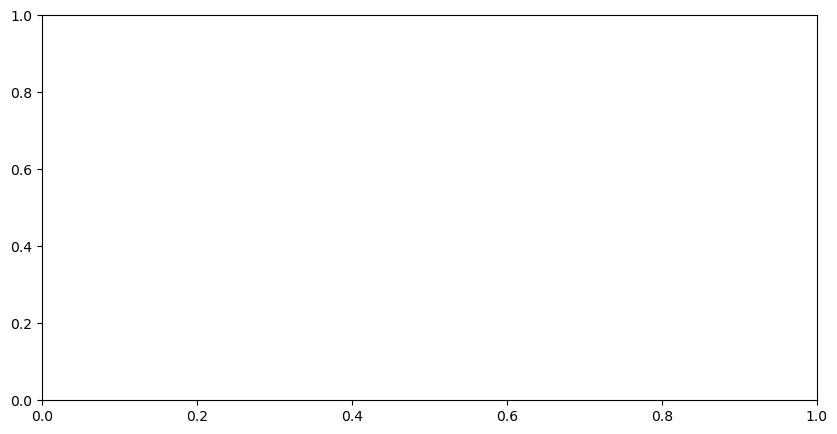

In [12]:
import pandas as pd

# Load metadata files
train_metadata = pd.read_csv('metadataTrain.csv')
test_metadata = pd.read_csv('metadataTest.csv')

# Display first few rows of the training metadata
print("Training Metadata:")
print(train_metadata.head())

# Display first few rows of the test metadata
print("\nTest Metadata:")
print(test_metadata.head())

# Summary statistics 
print("\nTraining Metadata Summary:")
print(train_metadata.describe(include='all'))

print("\nTest Metadata Summary:")
print(test_metadata.describe(include='all'))


#make some plot on the data of the metadata

# Plot the distribution of the training data
plt.figure(figsize=(10, 5))
plt.hist(train_metadata['AGE'], bins=20, color='blue', alpha=0.7, label='Training Data')
plt.hist(test_metadata['AGE'], bins=20, color='red', alpha=0.7, label='Test Data')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Training and Test Data')
plt.legend()
plt.show()


# Plot the distribution of the training data according to sex
plt.figure(figsize=(10, 5))
plt.hist(train_metadata['SEX'], bins=2, color='blue', alpha=0.7, label='Training Data')
plt.xlabel('SEX')
plt.ylabel('Frequency')
plt.title('SEX Distribution of Training Data')
plt.legend()
plt.show()


In [2]:

import pandas as pd
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.utils import resample

In [9]:


# Load metadata file
metadata = pd.read_csv('metadataTrain.csv')

# Select a reduced dataset of 1000 images
#metadata = metadata.sample(n=1000, random_state=42)

# Define a custom PyTorch dataset
class SkinLesionDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        image_id = self.metadata.iloc[idx]['ID']
        class_label = self.metadata.iloc[idx]['CLASS']
        # Load image
        try :
            image_path = os.path.join('Train/Train', f"{image_id}.jpg")
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        except:
            return None, None
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        return image, class_label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = SkinLesionDataset(metadata, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Display class distribution
print("Class Distribution:")
print(metadata['CLASS'].value_counts())


Class Distribution:
CLASS
2    9657
1    3391
3    2492
5    1968
4     650
8     471
7     190
6     179
Name: count, dtype: int64


In this code:
- We load the metadataTrain.csv file and select a reduced dataset of 1000 images using sample().
- We define a custom PyTorch dataset SkinLesionDataset that loads the images and corresponding labels.
- We apply transformations to the images using transforms.Compose(). The transformations include converting the image to a PIL image, resizing it to 224x224 pixels, and converting it to a PyTorch tensor.
- We create a DataLoader to batch and shuffle the data.

### balancing data

In [4]:
# making dfs for each class
df_1 = metadata[metadata['CLASS'] == 1]
df_2 = metadata[metadata['CLASS'] == 2]
df_3 = metadata[metadata['CLASS'] == 3]
df_4 = metadata[metadata['CLASS'] == 4]
df_5 = metadata[metadata['CLASS'] == 5]
df_6 = metadata[metadata['CLASS'] == 6]
df_7 = metadata[metadata['CLASS'] == 7]
df_8 = metadata[metadata['CLASS'] == 8]

n_samples = 1000

# Upsample minority classes
df_1_upsampled = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_upsampled = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_upsampled = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_upsampled = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_upsampled = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_upsampled = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
df_7_upsampled = resample(df_7, replace=True, n_samples=n_samples, random_state=42)
df_8_upsampled = resample(df_8, replace=True, n_samples=n_samples, random_state=42)


data_balanced = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, 
                           df_5_upsampled, df_6_upsampled, df_7_upsampled, df_8_upsampled])

print(data_balanced['CLASS'].value_counts())


CLASS
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
Name: count, dtype: int64


In [5]:
data_balanced.head()

,ID,CLASS,SEX,AGE,POSITION
17862,ISIC_0028415,1,male,60.0,NaN
5048,ISIC_0026963,1,male,65.0,head/neck
7365,ISIC_0058666,1,female,85.0,anterior torso
6436,ISIC_0027101,1,male,65.0,posterior torso
6256,ISIC_0061052,1,female,45.0,head/neck


In [ ]:
# read the images forfm the dataset and put them in the panda 

# Define a custom PyTorch dataset
data_balanced['IMAGE'] = data_balanced['ID'].apply(lambda x:  dataset.transform(cv2.imread(os.path.join('Train/Train', f"{x}.jpg"))))

In [ ]:
data_balanced.head()

torch.Size([3, 224, 224])
2


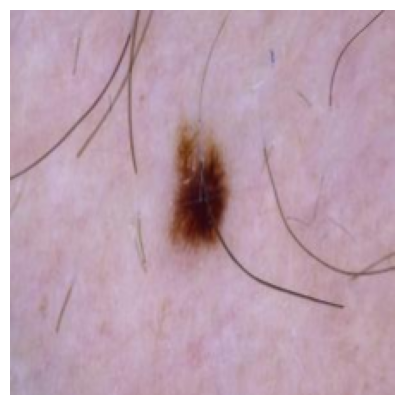

[ WARN:0@590.927] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0071222.jpg'): can't open/read file: check file path/integrity
[ WARN:0@590.927] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0069434.jpg'): can't open/read file: check file path/integrity
[ WARN:0@590.928] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0062098.jpg'): can't open/read file: check file path/integrity
[ WARN:0@590.928] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0057224.jpg'): can't open/read file: check file path/integrity
[ WARN:0@590.928] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0056307.jpg'): can't open/read file: check file path/integrity
[ WARN:0@590.940] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0067798.jpg'): can't open/read file: check file path/integrity
[ WARN:0@590.940] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0054278.jpg'): can't open/read file: check file path/integrity

Number of existing images: 7180


[ WARN:0@660.573] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0054342.jpg'): can't open/read file: check file path/integrity
[ WARN:0@660.573] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0031537.jpg'): can't open/read file: check file path/integrity
[ WARN:0@660.574] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0057701.jpg'): can't open/read file: check file path/integrity
[ WARN:0@660.574] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0031784.jpg'): can't open/read file: check file path/integrity
[ WARN:0@660.580] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0055246.jpg'): can't open/read file: check file path/integrity
[ WARN:0@660.580] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0059684.jpg'): can't open/read file: check file path/integrity
[ WARN:0@660.580] global loadsave.cpp:248 findDecoder imread_('Train/Train/ISIC_0058751.jpg'): can't open/read file: check file path/integrity

In [10]:
# try to retrieve an item 
image, class_label = dataset.__getitem__(0)
print(image.shape)
print(class_label)


# Display the first image  
plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()



def count_existing_images(dataset):
    count = 0
    for i in range(len(dataset)):
        image, _ = dataset.__getitem__(i)
        if image is not None:
            count += 1
    return count
print("Number of existing images:", count_existing_images(dataset))




# # Display the first 16 images
# plt.figure(figsize=(20, 20))
# for i in range(16):
#     ret = dataset.__getitem__(i) 
#     if ret is None:
#         continue
#     image, class_label = ret
#     plt.subplot(4, 4, i+1)
#     plt.imshow(image.permute(1, 2, 0))
#     plt.title(f"Class: {class_label}")
#     plt.axis('off')
     


### 1.2 Data Preprocessing


## 2. Feature Extraction:

After obtaining the dataset, we'll extract features from the images. The features we are interested in are:

Asymmetry: A measure of how symmetric the lesion is.
Border Irregularity: Describes the irregularity of the lesion's border.
Colour: Different color variations within the lesion.
Dimension: Size and shape of the lesion.

Feature Extraction Methods:

Asymmetry: Calculate the asymmetry by comparing the lesion's halves. A perfectly symmetrical lesion would have a symmetry score close to 1.
Border Irregularity: This can be quantified by measuring the smoothness of the lesion's border. A more irregular border would have a higher irregularity score.
Colour: Extract color histograms or use color channels to analyze the variation in colors within the lesion.
Dimension: Calculate the size (area, perimeter) and shape (aspect ratio, circularity) of the lesion.


## 3. Machine Learning Classification:

Once we have the features extracted, we can use machine learning algorithms to classify the images into the eight diagnostic classes. Some popular algorithms for image classification are:

    Support Vector Machine (SVM)
    Random Forest
    Convolutional Neural Networks (CNN)

Steps for Classification:

Data Preprocessing: Normalize and standardize the extracted features.
Feature Selection: Select the most relevant features using techniques like feature importance or feature selection algorithms.
Model Training: Train the chosen machine learning algorithm on the preprocessed and selected features.
Model Evaluation: Evaluate the model using metrics like accuracy, precision, recall, and F1-score on a separate test set.
Hyperparameter Tuning: Optimize the model's hyperparameters to improve performance.

## cnn 


In [3]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [1]:
import numpy as np 
import pandas as pdimport
import sklearn
import sklearn.metrics as sklm 
from glob import glob
import seaborn as sns
from PIL import Image

## here i will try to select the best model for the task
np.random.seed(42)
from  sklearn.metrics import confusion_matrix


from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.preprocessing import LabelEncoder
from scipy import stats

ski_df = pd.read_csv('metadataTrain.csv')


SIZE = 32

print(ski_df.head())



ModuleNotFoundError: No module named 'tensorflow'



## 4. Model Deployment:

Once the model is trained and evaluated, it can be deployed as an AI solution for skin lesion classification. This can be done as a web application, mobile app, or integrated into existing healthcare systems.
Tools and Libraries:

    Python: For data preprocessing, feature extraction, and machine learning.
    Scikit-learn: For machine learning algorithms and feature extraction.
    OpenCV: For image processing and feature extraction.
    TensorFlow/Keras: For building and training neural networks if CNNs are used.